In [1]:
import numpy as np
import argparse
import random
import time
from math import sqrt,ceil

# Homework 3 Andrea Serafini 277048

# The Cooking Chef Problem

The following class define the environment of the cooking chef problem, in this world there are the following elements:
-  representation of the state define the location of the agent and if it has an eggbeater in hand with a boolean variable ass follow: (row, col, has_beater)
-  walls: from (row,col) to : (row, col)
-  beater location (row, col)
-  ends (row, col)

For each reached cell (identified by row and col indexes) it is assigned a reward value, to avoid the agent to waste time or make error (e.g. try to pick a beater if he already have one in hand),  different rewards and penalty have been assigned as follow:

- step from a cell to another cell (penalty waste of time): -1
- cook bonus (positive reward): 30
- try cook in wrong position position (penalty): -3
- try cook without beater (penalty):-5
- pick beater (positive reward): 5
- try pick beater in wrong position position (penalty): -3
- try pick beater with a beater already in hand (penalty): -5
- hit wall:-5

The agent can perform 6 actions:

- MOVE LEFT = "l"
- MOVE RIGHT = "r"
- MOVE UP = "u"
- MOVE DOWN = "d"
- PICK BEATER = "p"
- COOK = "c"


Representation of the row and columns of the environments
I decided to invert the index of the board with the purpose to facilitate the implementation.

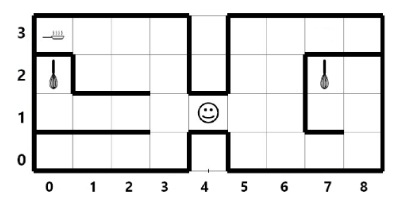

# Class world
This class define the environment representation in wich the agent 'play', it also contains the functions that define the change of a state related to te action.

In [2]:
class world:
    def __init__ (self, row, col, walls, beater, ends):
        self.row = row
        self.col = col
        self.walls = walls
        self.beater = beater
        self.ends = ends
        

        """ rewards specification """
        
        self.reward = {
            "step": -1,
            "cook_bonus": 30,
            "cook_penalty_position": -3,
            "cook_penalty_beater":-5,
            "pick_bonus": 5,
            "pick_penalty_position": -3,
            "already_picked_penalty": -5,
            "wall":-5
        }

    """ return value from the rewards dictionary """
    def get_reward (self, r_name):
        return self.reward[r_name]
        
    """ Check if end state has been reached """
    def reached_end (self, state,action):
        for e in self.ends:
            if state == e+(True,)and action == 'c':
                return True   
            else:
                return False
            
            
    """ next state: this function take as input the actual state and an action and return the resulting state """
    
    def next_state (self, actual_state, action):
        (row, col, has_beater) = actual_state
        
    # MOVE LEFT
        if action == "l":
            #print("LEFT")
            col = col-1
            if col < 0 or ((row,col+1),(row,col)) in self.walls:
                return actual_state
            elif has_beater :
                new_state = (row, col, True)
                return new_state
            else: 
                new_state = (row, col, False)
                return new_state
            
    # MOVE RIGHT
        if action == "r":
            #print("RIGHT")
            col += 1
            if col > self.col-1 or ((row,col-1),(row,col)) in self.walls :
                return actual_state
            elif has_beater :
                new_state = (row, col, True)
                return new_state
            else: 
                new_state = (row, col, False)
                return new_state
            
    # MOVE UP
        if action == "u":
            #print("UP")
            row += 1
            if row > self.row-1 or ((row-1,col),(row,col)) in self.walls :
                return actual_state
            elif has_beater :
                new_state = (row, col, True)
                return new_state
            else: 
                new_state = (row, col, False)
                return new_state
            
    # MOVE DOWN
        if action == "d":
           # print("DOWN")
            row -= 1
            if row < 0 or ((row+1,col),(row,col)) in self.walls :
                return actual_state
            elif has_beater :
                new_state = (row, col, True)
                return new_state
            else: 
                new_state = (row, col, False)
                return new_state
      # PICK  
        if action == "p":
            #print("PICK"+str(actual_state))
            if not has_beater and (row, col) in self.beater:
                new_state = (row, col, True)
                return new_state
            else:
                #print("PICK WRONG")
                return actual_state
      #COOK  
        if action == "c":
            #print("Cook")
            if has_beater and (row, col) in self.ends:
                new_state = (row, col, True)
                return new_state
            else:
                #print("COOK WRONG")
                return actual_state            
            
            
            

# Class Agent

This class define the agent behavior, in the specific it define the representation of an agent, the functions performed by the agents and some utility functions for the policy prints.


In [3]:
class agent:
        def __init__(self, start, actions, world, discount, learning_rate, epsilon, lamb, adaptive_epsilon):
            self.actions = actions
            self.world = world
            self.qtable = {}
            for i in range(world.row):
                for j in range(world.col):
                    for k in [False, True]:
                        for a in self.actions:
                            self.qtable[(i, j, k, a)] = 0
            self.start = start
            self.state = start
            self.discount = discount
            self.learning_rate = learning_rate
            self.epsilon = epsilon
            self.lamb = lamb
            self.adaptive_epsilon = adaptive_epsilon
        
        """ select an action in relation to the choosen epsilon value: Random Action if random < epsilon else Max Action """
        def select_action(self):
            if (np.random.uniform(0, 1) < self.epsilon):
                action = np.random.choice(self.actions)
            else:
                action = self.max_action(self.state)
            return action

        def max_action(self, state):
            action = np.random.choice(self.actions)
            maxq = self.qtable[state+(action,)]
            for a in self.actions:
                q = self.qtable[state+(a,)]
                if q > maxq:
                    maxq = q
                    action = a
            return action
    
    
        """perform an action, get the rewards and set the new Q table value"""
        
        def perform_action(self, action,world):
            next_state = self.world.next_state(self.state, action)
            next_action = self.max_action(next_state)
            (row, col)= self.state[0],self.state[1]
            #print(str((row, col)))
            if self.state[2]==True and action == "p":
                #print ('already in hand')
                # penalty if try to pick with a beater already in hand
                delta = - 5 +(self.world.get_reward("already_picked_penalty") +self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif self.state[2]==False and action == "p" and (row, col) in world.beater:
                #print ('bonus beater')
                # bonus if pick beater
                delta =  ( self.world.get_reward("pick_bonus") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif self.state[2]==False and action == "p" not in world.beater:
                #print ('penalty beater')
                # penalty if pick beater
                delta = ( self.world.get_reward("pick_penalty_position") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif self.state[2]==False and action == "c":
                #print ('penalty cook without beater')
                # penalty if try to cook without a beater already in hand
                delta = (self.world.get_reward("cook_penalty_beater") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif self.state[2]==True and action == "c" and (row, col) not in world.ends:
                #print ('penalty cook not in pans')
                # penalty if try to cook not in the pans
                delta = (self.world.get_reward("cook_penalty_position") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif self.state[2]==True and action == "c" and (row, col) in world.ends:
                # bonus cook
                #print('bonus cook')
                delta =( self.world.get_reward("cook_bonus") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif (self.state == next_state):
                #print ('different states')
                delta = (self.world.get_reward("wall") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            elif (self.state != next_state):
                delta = ( self.world.get_reward("step") + self.discount *self.qtable[next_state+(next_action,)]) - self.qtable[self.state+(action,)]
            # UPDATE QTABLE CELL
            self.qtable[(self.state[0], self.state[1], self.state[2], action)] += self.learning_rate * delta
            self.state = next_state
        

            
            
        def update_epsilon(self,episode):
                self.epsilon = 1/episode

        def play(self, episodes,world):
            t0 = time.time();
            current_ep = 1
            action =''
            while current_ep <= episodes:
                

                if self.adaptive_epsilon:
                    self.update_epsilon(current_ep)
                if self.world.reached_end(self.state,action):
                    #self.perform_action(action,world)
                    self.state = self.getRandomStart()
                    #print("Episode",current_ep,"Finished...",sep=" ")
                    current_ep += 1
                else:
                    action = self.select_action()
                    #print(self.state,action)
                    self.perform_action(action,world)
            t1 = time.time() - t0
            print ('episodes:'+str(episodes)+'in '+str(t1)+' seconds')

        """ random start avoiding the external environment cells """
        def getRandomStart(self):
            row = random.choice(range(self.world.row))
            col = random.choice(range(self.world.col))
            if (row, col) in [(0,4), (2, 4), (3,4)]:
                i = random.choice([-1, 1])
                return (row, col + i, False)
            if (row, col) in beater:
                return (row, col, True)
            else:
                return (row, col, False)


        def get_policy_sequence(self,start):
            state = start
            a = []
            check_finish=False
            while(not(check_finish)):
                action = self.max_action(state)
                check_finish=self.world.reached_end(state,action)
                a.append(action)
                state = self.world.next_state(state, action)
            return a

        def print_Q_table(self):
            print(self.qtable)

        def print_policy(self, start):
            print("Policy from start")
            state = start
            check_finish=False
            while(not(check_finish)):
                #print(check_finish)
                action = self.max_action(state)
                #print('MAX_ACTION'+str(action))
                check_finish=self.world.reached_end(state,action)
                #print(action, end=" -> ")
                print(state,action, end=" -> ")
                #print("print policy state" +str(state))
                #print("print policy action" +str(action))
                state = self.world.next_state(state, action)
                print(state)
            print("Finished")

        def print_policy_grid(self,with_beater):
            print("Optimal Policy")
            for r in range(self.world.row):
                for c in range(self.world.col):
                    for has_beater in [False, True]:
                        if with_beater == has_beater:
                            if (c == 4 and r != 1):
                                state = (r, c, has_beater)
                                print(state, "-",end =" | ")
                            else:
                                state = (r, c, has_beater)
                                action = self.max_action(state)
                                print(state, action,end =" | ")

        
        def get_policy_in_grid(self,with_beater):
            sequence = ""
            print("OptimalPolicy in the grid with beater ="+ str(with_beater))
            for r in range(self.world.row):
                for c in range(self.world.col):
                    for hb in [False, True]:
                        state = (r, c, hb)
                        action = self.max_action(state)
                        if with_beater == hb:
                            if (c == 4 and r != 1): 
                                sequence = sequence+"-"    
                            else:sequence = sequence+action 
            cells=self.world.row*self.world.col
            reverse = ""
            temp=""
            for r in range(self.world.row):
                temp=sequence[cells-self.world.col:cells]
                reverse = reverse + temp
                cells = cells - self.world.col
            return reverse

        def convert_position(s):
            try:
                row,col = map(int,s.split(","))
                return (row,col)
            except:
                raise argparse.ArgumentTypeError("arguments must be row,col")        

# Instance
In the next cell has been instantiated the World and The Agent, in this cells there is the possibility to change different parameter for the agents and create different worlds as follows:

#### worlds example

- walls = [((0,0),(1,0))] (define an obstacle from location (0,0) to location (1,0))
- start = (random.randint(0, 3),random.randint(0, 8), False)
- rows = 4 (rows of the environment)
- cols = 9 (columns of the environment)
- beater = [(2,0),(2,7)] (location of the eggbeaters)
- ends = [(3,0)] (location of the fryer pan)

#### agent example

- actions = ["u", "d", "l", "r", "p", "c"]
- discount = 0.8 (discount factor)
- learning_rate = 0.5
- epsilon = 0.3 (allow to agent to choose a random action with 30% of cases without this the agent will always choos the action from the q-table with the best value)
- number_of_episodes = 10000
- lamb = 0.5 (lambda)
- adaptive_epsilon = False/True (epsilon Decay during episodes)

In [4]:
walls = [
        ((0,0),(1,0)),((1,0),(0,0)),
        ((0,1),(1,1)),((1,1),(0,1)),
        ((0,2),(1,2)),((1,2),(0,2)),
        ((0,3),(0,4)),((0,4),(0,3)),
        ((0,4),(0,5)),((0,5),(0,4)),
        ((0,7),(1,7)),((1,7),(0,7)),
        ((1,1),(2,1)),((2,1),(1,1)),
        ((1,2),(2,2)),((2,2),(1,2)),
        ((1,4),(2,4)),((2,4),(1,4)),
        ((1,6),(1,7)),((1,7),(1,6)),
        ((2,0),(2,1)),((2,1),(2,0)),
        ((2,3),(2,4)),((2,4),(2,3)),
        ((2,4),(2,5)),((2,5),(2,4)),
        ((2,6),(2,7)),((2,7),(2,6)),
        ((2,7),(3,7)),((3,7),(2,7)),
        ((2,8),(3,8)),((3,8),(2,8)),
        ((3,3),(3,4)),((3,4),(3,3)),
        ((3,4),(3,5)),((3,5),(3,4)),
        ((2,0),(3,0)),((3,0),(2,0)),
        ((0,4),(1,4)),((1,4),(0,4))]
    

    
start = (random.randint(0, 3),random.randint(0, 8), False)
rows = 4
cols = 9
beater = [(2,0), (2,7)]
ends = [(3,0)]

w = world(rows, cols, walls, beater, ends)

actions = ["u", "d", "l", "r", "p", "c"]
discount = 0.8
learning_rate = 0.5
epsilon = 0.3
number_of_episodes = 10000
lamb = 0.5
adaptive_epsilon = False

a = agent(start, actions, w, discount, learning_rate, epsilon, lamb, adaptive_epsilon)




# Let's Play a Game!
In order to reach an optimal policy 10.000 episode have been played, in the following cells are showed the following results:


#### esapsed time for play the episodes

In [5]:
a.play(number_of_episodes,w)

episodes:10000in 17.01344633102417 seconds


In [3]:
#### Q Tablse values

In [6]:
a.print_Q_table()

{(0, 0, False, 'u'): -5.9609079337226785, (0, 0, False, 'd'): -5.960908186862158, (0, 0, False, 'l'): -5.960908218583131, (0, 0, False, 'r'): -1.2011352710302963, (0, 0, False, 'p'): -3.960924785705088, (0, 0, False, 'c'): -5.9609093584922554, (0, 0, True, 'u'): -4.75, (0, 0, True, 'd'): -5.62032344, (0, 0, True, 'l'): -6.12032344, (0, 0, True, 'r'): -3.5345533505000004, (0, 0, True, 'p'): -11.16118844, (0, 0, True, 'c'): -4.777823440000001, (0, 1, False, 'u'): -5.201135271027013, (0, 1, False, 'd'): -5.201135271030309, (0, 1, False, 'l'): -1.9609082168242402, (0, 1, False, 'r'): -0.2514190887878702, (0, 1, False, 'p'): -3.20113527103104, (0, 1, False, 'c'): -5.201135271031447, (0, 1, True, 'u'): -6.626700525, (0, 1, True, 'd'): -6.905259775, (0, 1, True, 'l'): -3.4812428061500005, (0, 1, True, 'r'): 20.220460781295657, (0, 1, True, 'p'): -1.6076429350521293, (0, 1, True, 'c'): -4.065, (0, 2, False, 'u'): -4.25141908878787, (0, 2, False, 'd'): -4.25141908878787, (0, 2, False, 'l'): -1.

#### Policy from start

In [7]:
a.print_policy(start)

Policy from start
(3, 7, False) l -> (3, 6, False)
(3, 6, False) d -> (2, 6, False)
(2, 6, False) l -> (2, 5, False)
(2, 5, False) d -> (1, 5, False)
(1, 5, False) l -> (1, 4, False)
(1, 4, False) l -> (1, 3, False)
(1, 3, False) l -> (1, 2, False)
(1, 2, False) l -> (1, 1, False)
(1, 1, False) l -> (1, 0, False)
(1, 0, False) u -> (2, 0, False)
(2, 0, False) p -> (2, 0, True)
(2, 0, True) d -> (1, 0, True)
(1, 0, True) r -> (1, 1, True)
(1, 1, True) r -> (1, 2, True)
(1, 2, True) r -> (1, 3, True)
(1, 3, True) u -> (2, 3, True)
(2, 3, True) u -> (3, 3, True)
(3, 3, True) l -> (3, 2, True)
(3, 2, True) l -> (3, 1, True)
(3, 1, True) l -> (3, 0, True)
(3, 0, True) c -> (3, 0, True)
Finished


#### policy with and without beater states

(for an easy read i decided to split the state: with and without beater)

In [8]:
a.print_policy_grid(True)

Optimal Policy
(0, 0, True) r | (0, 1, True) r | (0, 2, True) r | (0, 3, True) u | (0, 4, True) - | (0, 5, True) u | (0, 6, True) l | (0, 7, True) l | (0, 8, True) l | (1, 0, True) r | (1, 1, True) r | (1, 2, True) r | (1, 3, True) u | (1, 4, True) l | (1, 5, True) l | (1, 6, True) l | (1, 7, True) r | (1, 8, True) d | (2, 0, True) d | (2, 1, True) u | (2, 2, True) u | (2, 3, True) l | (2, 4, True) - | (2, 5, True) d | (2, 6, True) d | (2, 7, True) r | (2, 8, True) d | (3, 0, True) c | (3, 1, True) l | (3, 2, True) l | (3, 3, True) l | (3, 4, True) - | (3, 5, True) d | (3, 6, True) l | (3, 7, True) l | (3, 8, True) l | 

In [9]:
a.print_policy_grid(False)

Optimal Policy
(0, 0, False) r | (0, 1, False) r | (0, 2, False) r | (0, 3, False) u | (0, 4, False) - | (0, 5, False) u | (0, 6, False) l | (0, 7, False) r | (0, 8, False) u | (1, 0, False) u | (1, 1, False) l | (1, 2, False) l | (1, 3, False) l | (1, 4, False) l | (1, 5, False) l | (1, 6, False) l | (1, 7, False) u | (1, 8, False) u | (2, 0, False) p | (2, 1, False) r | (2, 2, False) r | (2, 3, False) d | (2, 4, False) - | (2, 5, False) d | (2, 6, False) l | (2, 7, False) p | (2, 8, False) l | (3, 0, False) r | (3, 1, False) d | (3, 2, False) r | (3, 3, False) d | (3, 4, False) - | (3, 5, False) d | (3, 6, False) d | (3, 7, False) l | (3, 8, False) l | 

# Print Grid 
It is an additional function used to visualize the posicy inside the environment, as befor the print has been divided in two cases with beater and without.
as remark the action performed by the agent are the following:

The agent can perform 6 actions:

- MOVE LEFT = "l"
- MOVE RIGHT = "r"
- MOVE UP = "u"
- MOVE DOWN = "d"
- PICK BEATER = "p"
- COOK = "c"

the best action of the policy is printed inside each cell of the environment.

In [1]:
def print_grid(s):
    grid_size = ceil(sqrt(len(s))) # A square size
    # print(grid_size)
    num_rows = 4 #grid_size
    num_cols = 9 #grid_size

    for row in range(num_rows):
        for col in range(num_cols-1):
            print("+---",end="")

        print("+---+")

        for col in range(num_cols):
            i = row*num_cols+col            
            c = s[i]  if i<len(s)  else " "

            print (f"| {c} ",end="")

        print("|")


    for col in range(num_cols-1):
        print("+---",end="")

    print("+---+")

#### OptimalPolicy in the grid with beater

In [11]:
print_grid(a.get_policy_in_grid(True))

OptimalPolicy in the grid with beater =True
+---+---+---+---+---+---+---+---+---+
| c | l | l | l | - | d | l | l | l |
+---+---+---+---+---+---+---+---+---+
| d | u | u | u | - | d | d | d | d |
+---+---+---+---+---+---+---+---+---+
| r | r | r | u | l | l | l | r | d |
+---+---+---+---+---+---+---+---+---+
| r | r | r | u | - | u | u | l | l |
+---+---+---+---+---+---+---+---+---+


#### OptimalPolicy in the grid without beater

In [12]:
print_grid(a.get_policy_in_grid(False))

OptimalPolicy in the grid with beater =False
+---+---+---+---+---+---+---+---+---+
| r | d | r | d | - | d | d | l | l |
+---+---+---+---+---+---+---+---+---+
| p | r | r | d | - | d | l | p | l |
+---+---+---+---+---+---+---+---+---+
| u | l | l | l | l | l | l | u | u |
+---+---+---+---+---+---+---+---+---+
| r | r | r | u | - | u | l | r | u |
+---+---+---+---+---+---+---+---+---+
